In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
N,C = 3,3
X_train,Y_train = [],[]
a,b = np.random.randint(0, 2**N, size=(2,10000))
c = a+b
c = c & (2**N-1)
X_train = (a << N) | b
Y_train = c

In [3]:
class QuantumOperator(keras.layers.Layer):
    
    def __init__(self, qubits, unitary_loss_factor=1., prob_loss_factor=1., **kwargs):
        self.dimension = 2**qubits
        self.unitary_loss_factor = unitary_loss_factor
        self.prob_loss_factor = prob_loss_factor
        super(QuantumOperator, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.operator_real = self.add_weight(
            shape=(self.dimension, self.dimension),
            initializer='glorot_normal', name='operator_real')
        self.operator_imag = self.add_weight(
            shape=(self.dimension, self.dimension),
            initializer='glorot_normal', name='operator_imag')
        super().build(input_shape)
    
    def call(self, inputs):
        operator = tf.complex(self.operator_real, self.operator_imag)
        forward = inputs @ operator
        unitary = operator @ tf.conj(tf.transpose(operator))
        prob = K.square(tf.abs(forward))
        self.add_loss(self.unitary_loss_factor/2 * K.sum(keras.losses.mae(
            tf.eye(self.dimension,self.dimension), tf.real(unitary))), inputs=inputs)
        self.add_loss(self.unitary_loss_factor/2 * K.sum(keras.losses.mae(
            tf.zeros((self.dimension,self.dimension)), tf.imag(unitary))), inputs=inputs)
        self.add_loss(self.prob_loss_factor * K.sum(keras.losses.mae(
            1., K.sum(prob, axis=-1))), inputs=inputs)
        return forward
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimension)

In [4]:
X = X_input = keras.layers.Input((1,), dtype='int32')
X = keras.layers.Lambda(lambda x: tf.complex(
    K.squeeze(K.one_hot(K.cast(x, 'int32'), 2**int(round(C*N))), axis=-2), 0.))(X)
X_operator = QuantumOperator(int(round(C*N)))
X = X_operator(X)
X = keras.layers.Lambda(lambda x: K.square(tf.abs(x)))(X)
X = keras.layers.Lambda(lambda x: K.sum(K.reshape(x,(-1,2**N,2**int(round((C-1)*N)))), axis=-1))(X)
M = keras.Model(X_input, X)
M.compile('nadam', 'sparse_categorical_crossentropy')
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 512)               0         
_________________________________________________________________
quantum_operator_1 (QuantumO (None, 512)               524288    
_________________________________________________________________
lambda_2 (Lambda)            (None, 512)               0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 8)                 0         
Total params: 524,288
Trainable params: 524,288
Non-trainable params: 0
_________________________________________________________________


In [5]:
M.fit(X_train, Y_train, epochs=500, batch_size=128, callbacks=[
    keras.callbacks.ReduceLROnPlateau('loss', patience=3, min_delta=0., verbose=1),
])

Epoch 1/500
10000/10000 [==============================] - 3s 298us/step - loss: 5.0248
Epoch 2/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.6849
Epoch 3/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.6292
Epoch 4/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.6251
Epoch 5/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.6189
Epoch 6/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.6085
Epoch 7/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.5976
Epoch 8/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.5879
Epoch 9/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.5792
Epoch 10/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.5712
Epoch 11/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.5639
Epoch 12/500
10000/10000 [====

10000/10000 [==============================] - 2s 180us/step - loss: 0.3104
Epoch 94/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.3088
Epoch 95/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.3071
Epoch 96/500
10000/10000 [==============================] - 2s 183us/step - loss: 0.3056
Epoch 97/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.3040
Epoch 98/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.3026
Epoch 99/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.3011
Epoch 100/500
10000/10000 [==============================] - 2s 179us/step - loss: 0.2996
Epoch 101/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.2984
Epoch 102/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2966
Epoch 103/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2953
Epoch 104/500
10000/10000 [===

10000/10000 [==============================] - 2s 180us/step - loss: 0.2244
Epoch 185/500
10000/10000 [==============================] - 2s 179us/step - loss: 0.2239
Epoch 186/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2234
Epoch 187/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2228
Epoch 188/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2227
Epoch 189/500
10000/10000 [==============================] - 2s 183us/step - loss: 0.2220
Epoch 190/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2216
Epoch 191/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2212
Epoch 192/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2205
Epoch 193/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.2200
Epoch 194/500
10000/10000 [==============================] - 2s 181us/step - loss: 0.2197
Epoch 195/500
10000/1000

10000/10000 [==============================] - 2s 180us/step - loss: 0.1984
Epoch 276/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.1982
Epoch 277/500
10000/10000 [==============================] - 2s 185us/step - loss: 0.1980
Epoch 278/500
10000/10000 [==============================] - 2s 184us/step - loss: 0.1980
Epoch 279/500
10000/10000 [==============================] - 2s 187us/step - loss: 0.1979
Epoch 280/500
10000/10000 [==============================] - 2s 182us/step - loss: 0.1976
Epoch 281/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.1978
Epoch 282/500
10000/10000 [==============================] - 2s 182us/step - loss: 0.1977
Epoch 283/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.1975
Epoch 284/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.1973
Epoch 285/500
10000/10000 [==============================] - 2s 180us/step - loss: 0.1972
Epoch 286/500
10000/1000


Epoch 00360: ReduceLROnPlateau reducing learning rate to 2.000000165480742e-08.
Epoch 361/500
10000/10000 [==============================] - 2s 180us/step - loss: 6.0613e-06
Epoch 362/500
10000/10000 [==============================] - 2s 179us/step - loss: 5.1484e-06
Epoch 363/500
10000/10000 [==============================] - 2s 179us/step - loss: 5.1547e-06
Epoch 364/500
10000/10000 [==============================] - 2s 179us/step - loss: 5.1591e-06
Epoch 365/500
10000/10000 [==============================] - 2s 180us/step - loss: 5.1557e-06

Epoch 00365: ReduceLROnPlateau reducing learning rate to 2.000000165480742e-09.
Epoch 366/500
10000/10000 [==============================] - 2s 179us/step - loss: 3.5579e-06
Epoch 367/500
10000/10000 [==============================] - 2s 179us/step - loss: 3.3887e-06
Epoch 368/500
10000/10000 [==============================] - 2s 179us/step - loss: 3.3844e-06
Epoch 369/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.3

10000/10000 [==============================] - 2s 194us/step - loss: 3.0531e-06
Epoch 431/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06
Epoch 432/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06

Epoch 00432: ReduceLROnPlateau reducing learning rate to 2.0000002470833968e-28.
Epoch 433/500
10000/10000 [==============================] - 2s 182us/step - loss: 3.0531e-06
Epoch 434/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06
Epoch 435/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06

Epoch 00435: ReduceLROnPlateau reducing learning rate to 2.000000247083397e-29.
Epoch 436/500
10000/10000 [==============================] - 2s 182us/step - loss: 3.0531e-06
Epoch 437/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06
Epoch 438/500
10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06

Epoc

10000/10000 [==============================] - 2s 181us/step - loss: 3.0531e-06


In [6]:
operator = X_operator.get_weights()
operator = operator[0].T + operator[1].T*1j

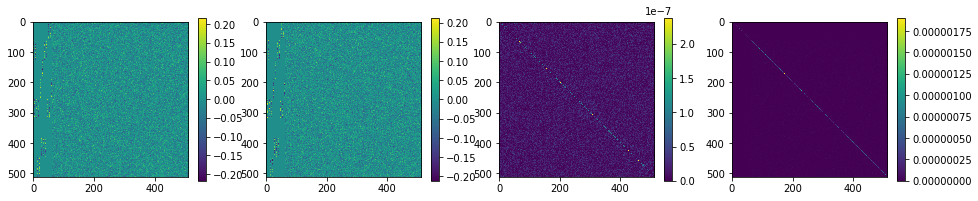

In [7]:
plt.figure(figsize=(16,3))
plt.subplot(1,4,1)
plt.imshow(np.real(operator))
plt.colorbar()
plt.subplot(1,4,2)
plt.imshow(np.imag(operator))
plt.colorbar()
plt.subplot(1,4,3)
plt.imshow(np.abs(np.real(operator @ np.conj(operator.T)) - np.eye(2**int(round(C*N)))))
plt.colorbar()
plt.subplot(1,4,4)
plt.imshow(np.abs(np.real(np.conj(operator.T) @ operator) - np.eye(2**int(round(C*N)))))
plt.colorbar()
plt.show()

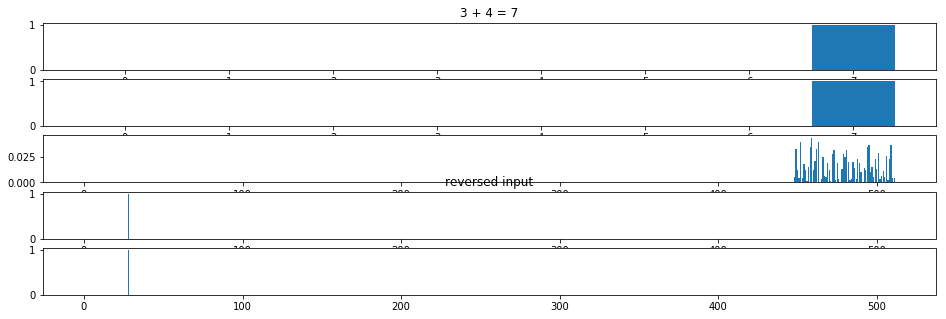

max prob by the regressed operator: 459 , sum of prob: 0.99999994


In [8]:
i = np.random.randint(0,len(X_train))
s = (operator @ keras.utils.to_categorical(X_train[i], num_classes=2**int(round(C*N))))
x = np.square(np.abs(np.conj(operator.T) @ s))
y = np.square(np.abs(s))
y_sum = np.sum(np.reshape(y,(2**N,2**int(round((C-1)*N)))), axis=-1)
plt.figure(figsize=(16,5))
plt.subplot(5,1,1)
plt.title(f'{a[i]} + {b[i]} = {c[i]}')
plt.bar(np.arange(2**N), y_sum)
plt.subplot(5,1,2)
plt.bar(np.arange(2**N), keras.utils.to_categorical(Y_train[i], num_classes=2**N))
plt.subplot(5,1,3)
plt.bar(np.arange(2**int(round(C*N))), y)
plt.subplot(5,1,4)
plt.title('reversed input')
plt.bar(np.arange(2**int(round(C*N))), x)
plt.subplot(5,1,5)
plt.bar(np.arange(2**int(round(C*N))), keras.utils.to_categorical(X_train[i], num_classes=2**int(round(C*N))))
plt.show()
print('max prob by the regressed operator:', np.argmax(y), ', sum of prob:', np.sum(y))

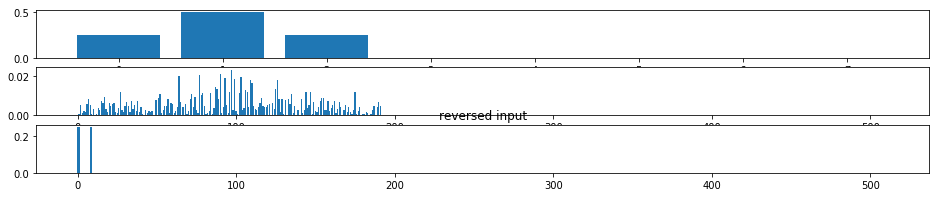

max prob by the regressed operator: 97 , sum of prob: 1.000000134051832


In [9]:
s = np.zeros((2**int(round(C*N)),))
s[(0 << N) | 1] = 1./np.sqrt(4)
s[(0 << N) | 0] = 1./np.sqrt(4)
s[(1 << N) | 1] = 1./np.sqrt(4)
s[(1 << N) | 0] = 1./np.sqrt(4)
s = (operator @ s)
x = np.square(np.abs(np.conj(operator.T) @ s))
y = np.square(np.abs(s))
y_sum = np.sum(np.reshape(y,(2**N,2**int(round((C-1)*N)))), axis=-1)
plt.figure(figsize=(16,3))
plt.subplot(3,1,1)
plt.bar(np.arange(2**N), y_sum)
plt.subplot(3,1,2)
plt.bar(np.arange(2**int(round(C*N))), y)
plt.subplot(3,1,3)
plt.title('reversed input')
plt.bar(np.arange(2**int(round(C*N))), x)
plt.show()
print('max prob by the regressed operator:', np.argmax(y), ', sum of prob:', np.sum(y))